In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pwd

/kaggle/working


In [5]:
!pip install torchsummary

In [6]:
!cp -r /kaggle/input/gtsrb-german-traffic-sign /kaggle/working/

# Import libraries

In [7]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np

# Data loader

In [8]:
class GTSRBDataLoader:
    def __init__(self, dataset_path, input_size=(224, 224), batch_size=64, num_workers=4, train=True):
        self.dataset_path = dataset_path
        self.input_size = input_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train = train

        # Define transformations
        self.transform = transforms.Compose([
            transforms.Resize(self.input_size),
            transforms.ToTensor(), # scaling [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization as per ImageNet
        ])

    def get_data_loader(self):
        dataset = datasets.GTSRB(root=self.dataset_path, split='train' if self.train else 'test', transform=self.transform, download=True)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        print(f"Dataset loaded with {len(dataset)} samples.")
        return dataset, data_loader

# Data visualization

In [9]:
class DataVisualizer:
    @staticmethod
    def show_batch(data_loader):
        data_iter = iter(data_loader)
        images, labels = next(data_iter)
        
        # Show images
        img_grid = torchvision.utils.make_grid(images)
        img_grid = img_grid / 2 + 0.5  # Unnormalize
        plt.figure(figsize=(12, 8))
        plt.imshow(img_grid.numpy().transpose((1, 2, 0)))
        plt.title('Batch from GTSRB Dataset')
        plt.axis('off')
        plt.show()

        # Print labels
        print(f"Labels in the batch: {labels.tolist()}")

    @staticmethod
    def plot_class_distribution(dataset):
        # Count the number of instances per class
        class_counts = Counter([label for _, label in dataset])

        # Print the total number of classes
        num_classes = len(class_counts)
        print(f"Total number of classes: {num_classes}")

        # Plotting the class distribution
        plt.figure(figsize=(12, 6))
        sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
        plt.title("Class Distribution in GTSRB Dataset")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.show()

        # Detailed distribution of image counts per class
        class_count_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
        class_count_df.sort_values('Count', ascending=False, inplace=True)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=class_count_df.index, y=class_count_df['Count'], palette='viridis')
        plt.title("Detailed Class Distribution")
        plt.xlabel("Class ID")
        plt.ylabel("Number of Images")
        plt.show()

    @staticmethod
    def plot_sample_images(dataset, num_samples=1):
        # Infer the number of classes from the dataset
        labels = [label for _, label in dataset]
        num_classes = len(set(labels))

        fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 2, num_classes * 2))

        # Ensure axes is always an iterable object
        if num_classes == 1:
            axes = np.array([axes])
        elif num_samples == 1:
            axes = np.array([axes]).T

        for class_idx in range(num_classes):
            # Filter images by the current class
            class_images = [img for img, label in dataset if label == class_idx]
            if len(class_images) > 0:
                img = class_images[0] / 2 + 0.5  # Unnormalize
                axes[class_idx].imshow(img.permute(1, 2, 0).numpy())
                axes[class_idx].axis('off')
            else:
                axes[class_idx].axis('off')

        plt.suptitle("Sample Images per Class", fontsize=16)
        plt.show()

    @staticmethod
    def plot_image_size_distribution(dataset):
        # Get image dimensions
        dimensions = [img.size[::-1] for img, _ in dataset]
        dim_df = pd.DataFrame(dimensions, columns=["Height", "Width"])
        
        # Distribution of unique shapes
        shape_counts = dim_df.value_counts().reset_index(name='Count')

        # Plotting height distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(dim_df["Height"], kde=True, color='orange', bins=30)
        plt.title("Height Distribution of Images")
        plt.xlabel("Height")
        plt.ylabel("Frequency")
        plt.show()
        
        # Plotting width distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(dim_df["Width"], kde=True, color='blue', bins=30)
        plt.title("Width Distribution of Images")
        plt.xlabel("Width")
        plt.ylabel("Frequency")
        plt.show()

        # Plot distribution of image shapes
        plt.figure(figsize=(12, 6))
        sns.barplot(x=shape_counts.index, y=shape_counts['Count'], palette='magma')
        plt.xticks(ticks=range(len(shape_counts)), labels=[f"{int(h)}x{int(w)}" for h, w in zip(shape_counts['Height'], shape_counts['Width'])], rotation=90)
        plt.title("Distribution of Image Shapes (Height x Width)")
        plt.xlabel("Shape")
        plt.ylabel("Frequency")
        plt.show()

100%|██████████| 187490228/187490228 [00:08<00:00, 23040480.90it/s]


Extracting GTSRB/gtsrb/GTSRB-Training_fixed.zip to GTSRB/gtsrb
Dataset loaded with 26640 samples.


100%|██████████| 88978620/88978620 [00:06<00:00, 13222020.25it/s]


Extracting GTSRB/gtsrb/GTSRB_Final_Test_Images.zip to GTSRB/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 217072.50it/s]


Extracting GTSRB/gtsrb/GTSRB_Final_Test_GT.zip to GTSRB/gtsrb
Dataset loaded with 12630 samples.


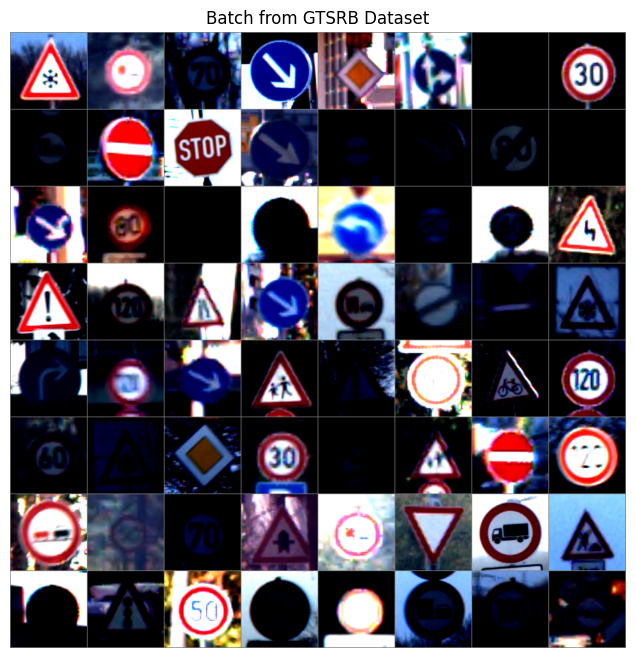

Labels in the batch: [30, 10, 4, 38, 12, 36, 4, 1, 10, 17, 14, 38, 9, 38, 6, 4, 38, 5, 1, 3, 34, 5, 3, 21, 18, 8, 24, 38, 10, 32, 17, 30, 33, 8, 38, 28, 18, 2, 29, 8, 3, 30, 12, 1, 31, 28, 17, 8, 9, 2, 4, 11, 10, 13, 16, 25, 3, 26, 2, 10, 7, 10, 7, 9]


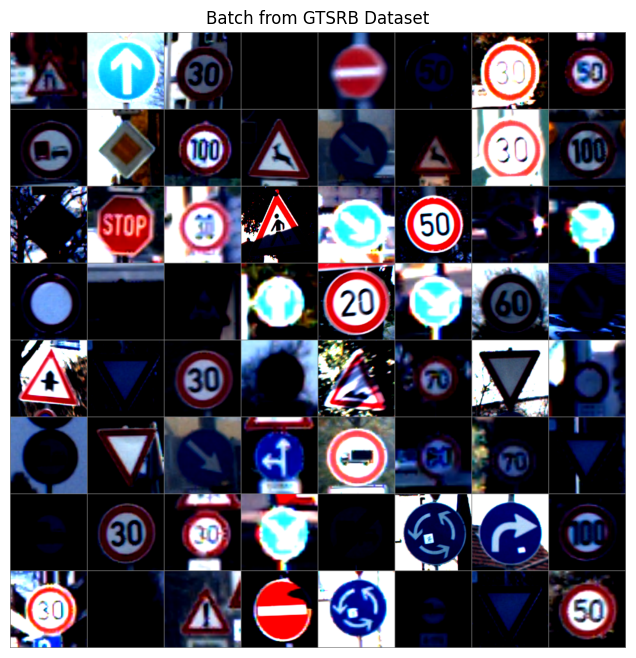

Labels in the batch: [24, 35, 1, 12, 17, 2, 1, 2, 10, 12, 7, 31, 38, 31, 1, 7, 12, 14, 1, 27, 38, 2, 38, 38, 15, 31, 23, 35, 0, 38, 3, 38, 11, 13, 1, 10, 22, 4, 13, 15, 10, 13, 38, 37, 16, 5, 4, 13, 10, 1, 1, 38, 42, 40, 33, 7, 1, 4, 18, 17, 40, 10, 13, 2]


In [10]:
# Configuration
DATASET_PATH = "./GTSRB"

# Initialize DataLoader 
data_loader_obj = GTSRBDataLoader(DATASET_PATH, input_size=(224, 224), batch_size=64, train=True)
train_dataset, train_loader = data_loader_obj.get_data_loader()

test_data_loader_obj = GTSRBDataLoader(DATASET_PATH, input_size=(224, 224), batch_size=64, train=False)
test_dataset, test_loader = test_data_loader_obj.get_data_loader()

# Visualize a batch of data from the training set
DataVisualizer.show_batch(train_loader)

# Visualize a batch of data from the test set (optional)
DataVisualizer.show_batch(test_loader)

Total number of classes: 43


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


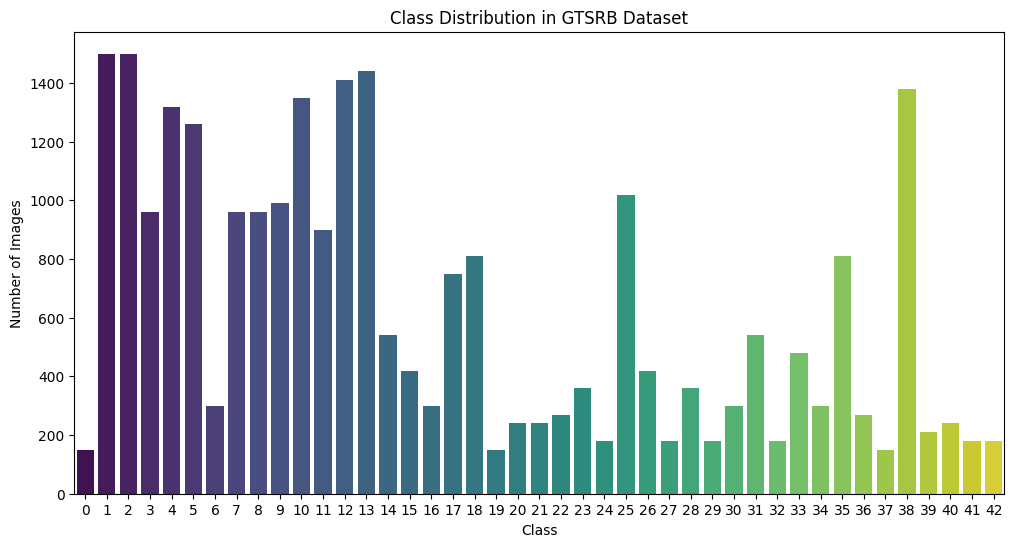

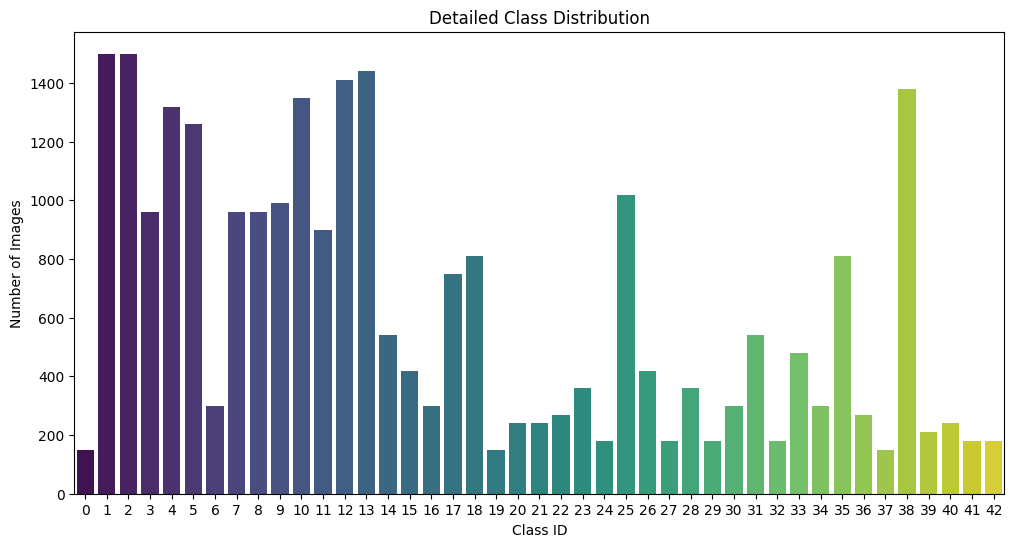

In [11]:
# Plot class distribution
DataVisualizer.plot_class_distribution(train_dataset)

# Model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from sklearn.metrics import classification_report
import numpy as np

# Load the pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes in the GTSRB dataset
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_labels = []
        all_preds = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Collect predictions
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
            running_loss += loss.item()
        
        # Calculate and print epoch loss
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Generate and print classification report after the final epoch
    print("Final Training Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(num_classes)]))

In [15]:
def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate and print accuracy
    accuracy = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Accuracy: {accuracy:.2f}%')

    # Generate and print classification report for test data
    print("Test Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(num_classes)]))

# Model Summary

In [16]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Training

In [17]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.3274
Epoch [2/10], Loss: 0.0532
Epoch [3/10], Loss: 0.0364
Epoch [4/10], Loss: 0.0291
Epoch [5/10], Loss: 0.0253
Epoch [6/10], Loss: 0.0332
Epoch [7/10], Loss: 0.0183
Epoch [8/10], Loss: 0.0185
Epoch [9/10], Loss: 0.0212
Epoch [10/10], Loss: 0.0126
Final Training Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       150
     Class 1       1.00      1.00      1.00      1500
     Class 2       0.99      0.99      0.99      1500
     Class 3       0.99      0.99      0.99       960
     Class 4       1.00      1.00      1.00      1320
     Class 5       0.99      0.99      0.99      1260
     Class 6       1.00      1.00      1.00       300
     Class 7       1.00      1.00      1.00       960
     Class 8       1.00      1.00      1.00       960
     Class 9       1.00      1.00      1.00       990
    Class 10       1.00      1.00      1.00      1350
    Class 11       1.00      1.00      1.0

# Evaluation

In [18]:
evaluate_model(model, test_loader)

Accuracy: 96.19%
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99        60
     Class 1       1.00      0.98      0.99       720
     Class 2       0.98      0.99      0.99       750
     Class 3       0.99      0.87      0.93       450
     Class 4       1.00      0.99      0.99       660
     Class 5       0.94      0.99      0.96       630
     Class 6       0.90      1.00      0.95       150
     Class 7       1.00      0.98      0.99       450
     Class 8       0.98      0.96      0.97       450
     Class 9       0.82      1.00      0.90       480
    Class 10       1.00      0.99      0.99       660
    Class 11       0.94      0.97      0.95       420
    Class 12       0.99      0.95      0.97       690
    Class 13       1.00      0.99      0.99       720
    Class 14       0.89      1.00      0.94       270
    Class 15       0.97      0.99      0.98       210
    Class 16       0.97      0.90   

# Test with online images

In [19]:
import requests
from PIL import Image
from torchvision import transforms
import torch
import io

# URL of the online image
image_url = "https://c8.alamy.com/comp/KGKFP7/traffic-sign-roundabout-germany-KGKFP7.jpg"

# Download the image
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content)).convert("RGB")

# Print original image details
print("Original Image (PIL format):")
print("Type:", type(img))
print("Size:", img.size)
print("Pixel Values (at [0,0]):", img.getpixel((0, 0)))

# Resize the image
resized_img = transforms.Resize((224, 224))(img)

# Convert to tensor
img_tensor = transforms.ToTensor()(resized_img)

# Print tensor details after ToTensor()
print("\nAfter ToTensor:")
print("Type:", type(img_tensor))
print("Size:", img_tensor.size())
print("Pixel Values (at [0,0]):", img_tensor[:, 0, 0])  # Print pixel values at [0,0]

# Normalize the tensor
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_normalized = normalize(img_tensor)

# Print normalized tensor details
print("\nAfter Normalization:")
print("Type:", type(img_normalized))
print("Size:", img_normalized.size())
print("Pixel Values (at [0,0]):", img_normalized[:, 0, 0])  # Print pixel values at [0,0]

# Add batch dimension and move to device
img_tensor = img_normalized.unsqueeze(0).to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = output.max(1)

# Map the predicted label to the class name
predicted_class = f"Class {predicted.item()}"
print(f"\nThe model predicts: {predicted_class}")
# 0-255

Original Image (PIL format):
Type: <class 'PIL.Image.Image'>
Size: (1300, 1047)
Pixel Values (at [0,0]): (198, 197, 193)

After ToTensor:
Type: <class 'torch.Tensor'>
Size: torch.Size([3, 224, 224])
Pixel Values (at [0,0]): tensor([0.7725, 0.7686, 0.7529])

After Normalization:
Type: <class 'torch.Tensor'>
Size: torch.Size([3, 224, 224])
Pixel Values (at [0,0]): tensor([1.2557, 1.3957, 1.5420])

The model predicts: Class 40


# Save the model

In [20]:
import torch

# Save the entire model to a file
torch.save(model, 'traffic_sign_recognition_resNet50_model.pth')

# Load and use model

In [21]:
import requests
from PIL import Image
from torchvision import transforms
import torch
import io

# Load the saved model
model = torch.load('/kaggle/working/traffic_sign_recognition_resNet50_model.pth')
model.eval()  # Set the model to evaluation mode

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move model to the appropriate device

# URL of the online image
image_url = "https://s3.envato.com/files/466099867/OcsqoZ0P53jXpnbbxdTM1Cykx2JmJ2j1ZdB72OHD.jpeg"

# Download the image
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content)).convert("RGB")

# Print original image details
print("Original Image (PIL format):")
print("Type:", type(img))
print("Size:", img.size)
print("Pixel Values (at [0,0]):", img.getpixel((0, 0)))

# Resize the image
resized_img = transforms.Resize((224, 224))(img)

# Convert to tensor
img_tensor = transforms.ToTensor()(resized_img)

# Print tensor details after ToTensor()
print("\nAfter ToTensor:")
print("Type:", type(img_tensor))
print("Size:", img_tensor.size())
print("Pixel Values (at [0,0]):", img_tensor[:, 0, 0])  # Print pixel values at [0,0]

# Normalize the tensor
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_normalized = normalize(img_tensor)

# Print normalized tensor details
print("\nAfter Normalization:")
print("Type:", type(img_normalized))
print("Size:", img_normalized.size())
print("Pixel Values (at [0,0]):", img_normalized[:, 0, 0])  # Print pixel values at [0,0]

# Add batch dimension and move to device
img_tensor = img_normalized.unsqueeze(0).to(device)

# Make a prediction
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = output.max(1)

# Map the predicted label to the class name
predicted_class = f"Class {predicted.item()}"
print(f"\nThe model predicts: {predicted_class}")

Original Image (PIL format):
Type: <class 'PIL.Image.Image'>
Size: (590, 393)
Pixel Values (at [0,0]): (210, 212, 209)

After ToTensor:
Type: <class 'torch.Tensor'>
Size: torch.Size([3, 224, 224])
Pixel Values (at [0,0]): tensor([0.8353, 0.8471, 0.8431])

After Normalization:
Type: <class 'torch.Tensor'>
Size: torch.Size([3, 224, 224])
Pixel Values (at [0,0]): tensor([1.5297, 1.7458, 1.9428])

The model predicts: Class 4
